In [6]:
pix = 0.0225*2 #1pixel=0.0225µm

In [77]:
fociID = input()

0F


In [132]:
%matplotlib inline
import numpy as np
import pandas as pdz
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
celldf = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/results/Results_pos%s.xls' %fociID,sep='\t')

In [133]:
celldf  = celldf.drop('Mean',1)
celldf = celldf.drop('X',1)
celldf = celldf.drop('Y',1)
celldf = celldf.drop('Perim.',1)
celldf = celldf.drop('Major',1)
celldf = celldf.drop('Minor',1)
celldf.Area = celldf.Area*(pix**2)
celldf.XM = celldf.XM*pix
celldf.YM = celldf.YM*pix
celldf.head(3)

,,Label,Area,XM,YM,Angle
0,1,Binarized:0400-0473-0754:Pos00399,0.656100,33.99777,21.295845,117.453
1,2,Binarized:0399-0473-0754:Pos00398,0.641925,33.95916,21.306915,120.548
2,3,Binarized:0398-0474-0753:Pos00397,0.617625,33.92415,21.313395,119.348


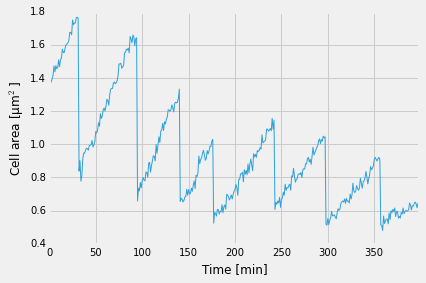

In [134]:
#Original data is in reverse-chronological because of backwards tracking in ImageJ
#Reverse order here so dataframe matches chronological order
celldf =celldf.reindex(index=celldf.index[::-1])
celldf = celldf.reset_index(drop=True)
ax1 = celldf.Area.plot(linewidth=1)
ax1.set_ylabel(r'Cell area [µm$^2$]')
ax1.set_xlabel('Time [min]')
plt.tight_layout()
filename = "Cell_Area_%s.pdf"%fociID
savedir ='/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/Graphs/'
#plt.savefig(savedir+filename)

In [135]:
celldf.head(3)

,,Label,Area,XM,YM,Angle
0,399,Binarized:0002-0595-0697:Pos00001,1.368900,31.433085,26.77473,1.525
1,398,Binarized:0003-0595-0697:Pos00002,1.381050,31.413015,26.77815,0.727
2,397,Binarized:0004-0595-0697:Pos00003,1.374975,31.427010,26.77230,1.251


In [136]:
focidf = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/FociResults/FociResults_Pos%s.xls'%fociID,sep='\t')


focidf = focidf.drop('Label', 1)
focidf = focidf.drop('Min', 1)
focidf = focidf.drop('Max', 1)
focidf = focidf.drop('Slice', 1)
focidf = focidf.drop(399) #the cell ROI data lacks the first slice, so delete it here to match
focidf.XM = focidf.XM*pix
focidf.YM = focidf.YM*pix
focidf =focidf.reindex(index=focidf.index[::-1])
focidf = focidf.reset_index(drop=True)
cellfocidisp = ((celldf.XM-focidf.XM)**2+(celldf.YM-focidf.YM)**2)**(1/2) 
#cellfocidisp.plot(label = 'Distance between Cell Center and Foci').legend(loc='upper left', bbox_to_anchor=(1, 0.5))

In [137]:
brightness = pd.read_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/BrightnessResults/BrightnessResults_Pos%s.xls'%fociID,sep='\t')
brightness = brightness.drop('Min',1)
brightness = brightness.drop(' ',1)
brightness = brightness.drop(399)
brightness.Max.head(10).mean()

884.3

In [138]:
cellyt = celldf['YM']
len(cellyt)

399

In [139]:
cellx = celldf['XM']
celly = celldf['YM']
focix = focidf['XM']
fociy = focidf['YM']

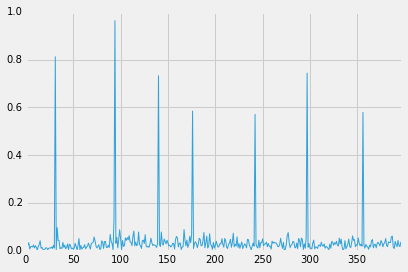

In [140]:
celldisp = pd.Series(((cellx[i+1]-cellx[i])**2+(celly[i+1]-celly[i])**2)**(1/2) for i in range (len(cellx)-1))
celldisp.plot(lw=1)
cartdispv = pd.Series(((focix[i+1]-focix[i]-cellx[i+1]+cellx[i])**2+(fociy[i+1]-fociy[i]-celly[i+1]+celly[i])**2)**(1/2) for i in range (len(cellx)-1))

In [141]:
celldf5min = celldf.iloc[::30]
celldf5min = celldf5min.reset_index(drop=True)
focidf5min = focidf.iloc[::30]
focidf5min = focidf5min.reset_index(drop=True)
cellx5 = celldf5min['XM']
celly5 = celldf5min['YM']
focix5 = focidf5min['XM']
fociy5 = focidf5min['YM']
celldisp5 = pd.Series(((cellx5[i+1]-cellx5[i])**2+(celly5[i+1]-celly5[i])**2)**(1/2) for i in range (len(cellx5)-1))
cartdisp5 = pd.Series(((focix5[i+1]-focix5[i])**2+(fociy5[i+1]-fociy5[i])**2)**(1/2) for i in range (len(focix5)-1))
cartdispv5 = pd.Series(((focix5[i+1]-focix5[i]-cellx5[i+1]+cellx5[i])**2+(fociy5[i+1]-fociy5[i]-celly5[i+1]+celly5[i])**2)**(1/2) for i in range (len(cellx5)-1))

#for x in celldisp5:
   # if x>0.5:
        #celldisp5[celldisp5 == x]=celldisp5.mean()
        #cartdispv5[celldisp5 == x]=cartdispv5.mean()

In [142]:
cartdispv.std()/cartdispv.mean()

1.2625703581786754

In [143]:
cartdispv5.std()/cartdispv5.mean()

0.5775626952031264

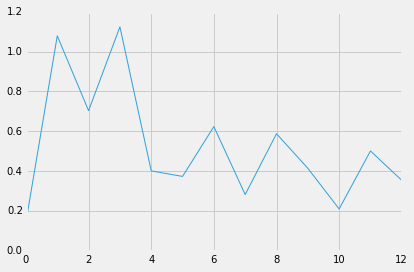

In [144]:
cartdispv5.plot(lw=1)

In [145]:
cartdispv.head(2)

0    0.080073
1    0.068098
dtype: float64

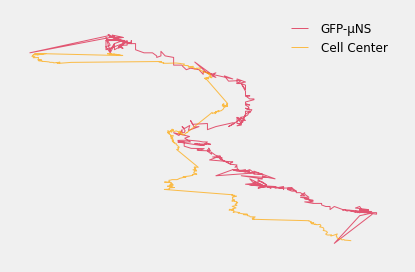

In [146]:
plt.figure();
plt.plot(focidf.XM, focidf.YM, 'crimson',alpha = 0.7, label = 'GFP-µNS',linewidth=1)
plt.plot(celldf.XM, celldf.YM, 'orange', alpha = 0.7, label = 'Cell Center',linewidth=1)
plt.legend()
plt.axis('off')
#plt.plot([18.0, 18.5], [9, 9], 'k-', lw=3) #scale bar = 0.5µm
filename = "cellfocitrack%s.pdf"%fociID
#plt.savefig(savedir+filename)

/Users/kaito/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


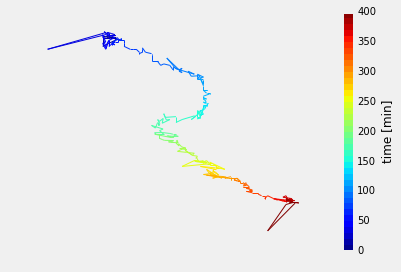

In [147]:
#Create time-coloured trajectory
from matplotlib.collections import LineCollection
from matplotlib import cm

xy = focidf[['XM','YM']].values
z = np.linspace(0, 1, len(focidf))

min, max = (0, len(focidf))
step = 10 #step in color bar

#Using contourf to provide colorbar info, then clearing the figure
Q = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Q, levels, cmap=cm.jet)
plt.clf()

lc = LineCollection(zip(xy[:-1], xy[1:]), array=z, cmap=cm.jet,linewidth=1)

fig,  ax = plt.subplots(1, 1)
ax.add_collection(lc)
ax.margins(0.1)
ax2= fig.colorbar(CS3)
ax2.set_label('time [min]')
#plt.show()
plt.axis('off')
#plt.plot([16.0, 16.5], [9, 9], 'k-', lw=3)
fig1 = plt.gcf()
filename = "focitrajectory%s.pdf"%fociID

#fig1.savefig(savedir+filename)

References for above plot:

http://stackoverflow.com/questions/32039080/cmap-for-use-with-line-plot

http://stackoverflow.com/questions/17682613/how-to-convert-a-pandas-dataframe-subset-of-columns-and-rows-into-a-numpy-array

http://villageofsound.hatenadiary.jp/entry/2015/09/13/010352

http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots

It might be interesting if I normalize several foci's coordinates (by setting initial position as [0,0]), and plotting all the trajectories into the same heatmap. Looks like the foci is largely confined in the beginning (which is the result of cell position), moves with the cell, and moves rather vigourously in the last segment (at least in foci4A-C).

$$ \mbox{MSD}(\Delta t) = \frac{\sum_0^{T - \Delta t} ||\mathbf{r}(t + \Delta t) - \mathbf{r}(t)||^2}{(T - \Delta t) / \delta t} = \frac{d_{t, t+\Delta t}}{(T - \Delta t) / \delta t} $$

In [148]:
## Number of points in the trajectories
#n_points = 1000

## Time step between two points
t_step = 1

msddf = focidf.drop(' ',1)
msddf.index=pd.Index(np.arange(len(msddf)), name='t_stamp')
msddf['t'] = np.arange(len(msddf)) * t_step

def compute_msd(trajectory, t_step, coords=['XM', 'YM']):
    numberofDeltaT = int(np.floor(len(trajectory)/4))
    delays = trajectory.t[:numberofDeltaT]
    shifts = np.floor(delays/t_step).astype(np.int)
    msds = np.zeros(numberofDeltaT, dtype=object)
    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
    return delays, msds

(0, 5)

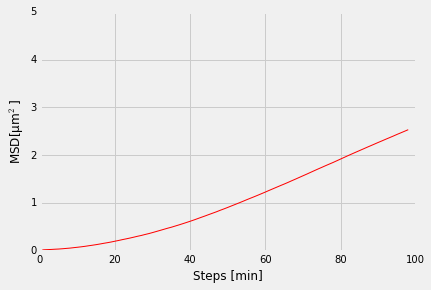

In [149]:
delays, msds = compute_msd(msddf, t_step=t_step)


plt.plot(delays, msds, '-r',lw=1)
plt.xlabel('Steps [min]')
plt.ylabel(r'MSD[µm$^2$]')
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(0,5)

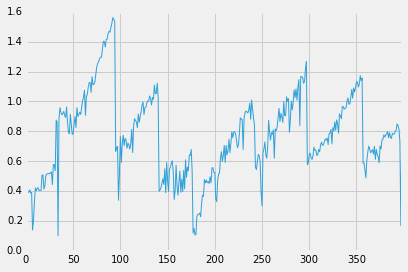

In [150]:
cellfocidisp.plot(lw=1)

In [151]:
#t_step = 2
#numberofDeltaT = int(np.floor(len(msddf)/4))
#delays = msddf.t[:numberofDeltaT]
#shifts = np.floor(delays[:numberofDeltaT]/t_step).astype(np.int)
#msds1 = np.zeros(numberofDeltaT)
#for i, shift in enumerate(shifts):
#       diffs = msddf[['XM','YM']] -msddf[['XM','YM']].shift(-shift)
#      sqdist = np.square(diffs).sum(axis=1)
#      msds1[i] = sqdist.mean()

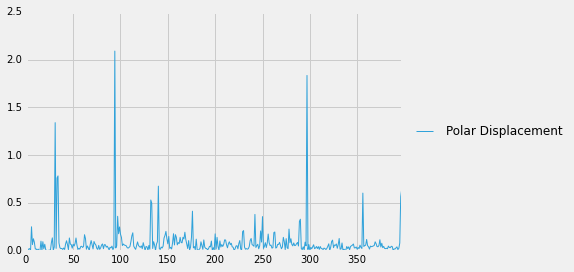

In [152]:
rad = np.radians(celldf['Angle']) #convert cell ROI long axis angle to radians
radfoci = rad-np.arctan2(focidf['YM'],focidf['XM']) #convert foci polar coordinate theta taking into account the ROI's angle

polardisp= pd.Series((cellfocidisp[i+1]**2+cellfocidisp[i]**2-2*cellfocidisp[i]*cellfocidisp[i+1]*np.cos(radfoci[i+1]-radfoci[i]))**(1/2) for i in range (len(cellfocidisp)-1))

polardisp.plot(label = 'Polar Displacement',lw=1).legend(loc='center left', bbox_to_anchor=(1, 0.5))

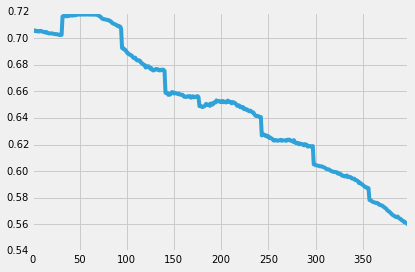

In [153]:
np.arctan2(celldf['YM'],celldf['XM']).plot()

In [154]:
polardf=pd.DataFrame()
polardf['r'] = cellfocidisp
polardf['theta'] = radfoci
polardf['rcostheta'] = cellfocidisp*np.cos(radfoci)



In [155]:
#Replace the outliers in Polar displacements with mean
celldisp2 =celldisp.copy()
#for x in celldisp:
 #   if x>0.4:
#      polardisp[celldisp == x] = polardisp.mean()
#     celldisp2[celldisp == x] = celldisp2.mean()
#for x in cartdispv:
 #   if x>0.4:
#       cartdispv[cartdispv == x]=cartdispv.mean()

In [156]:
for x in celldisp:
    if x>0.4:
        divindex = celldisp[celldisp ==x].index[0]
        polardisp[divindex] = polardisp.mean()
        

In [157]:
polardisp[polardisp == polardisp.max()]

34    0.783086
dtype: float64

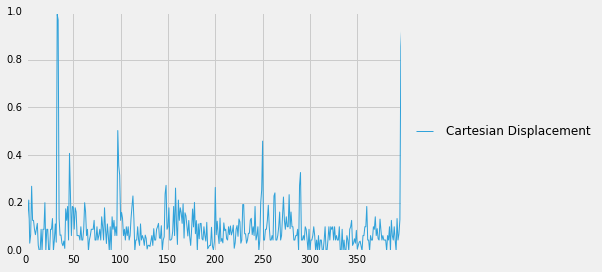

In [158]:
focix = focidf['XM']
fociy = focidf['YM']
cartdisp = pd.Series(((focix[i+1]-focix[i])**2+(fociy[i+1]-fociy[i])**2)**(1/2) for i in range (len(focix)-1))
#cartdisp2 = pd.Series(np.linalg.norm(a-b))
cartdisp.plot(label = 'Cartesian Displacement',lw=1).legend(loc='center left', bbox_to_anchor=(1, 0.5))

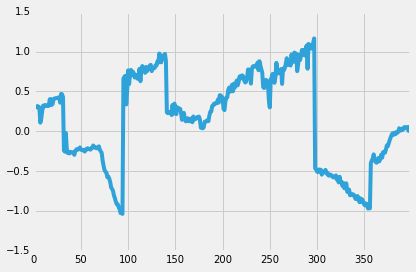

In [159]:
polardf.rcostheta.plot()

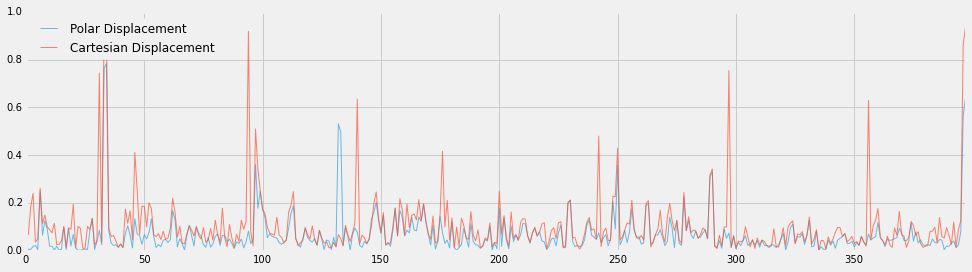

In [160]:
ax = polardisp.plot(label = 'Polar Displacement', alpha = 0.7,linewidth=1,figsize=(15,4))
cartdispv.plot( label = 'Cartesian Displacement', alpha = 0.7,linewidth=1, ax=ax)

ax.legend(loc='upper left')

#celldf.Area.plot(a label = 'Cell Area',  alpha = 0.7)


In [175]:
dispdf = pd.DataFrame({'Cartesian': cartdisp, 'Polar': polardisp})
#dispdf.head(3)

#plt.figure();
#dispdf.hist(bins=[0,4,8,12,16], color='Black', alpha=0.7)

In [315]:
#extract division timepoints
division = celldisp[celldisp>0.4].index 

#Set generation number for each timepoint
generation = pd.Series(range(len(polardisp)+1))

for i in range(len(division)+1):
    if i == 0: #Generation1
        generation[:division[i]+1]= 1
    elif i == len(division): #Last Generation
        generation[division[i-1]:]=i+1
    else:    
        generation[division[i-1]+1:division[i]+1]= i+1

In [319]:
celldisp[93]

0.076904052071393433

In [240]:
celldf['Foci X'] = focix
celldf['Foci Y'] = fociy
celldf['Cartesian_Displacement'] = cartdisp
celldf['Polar_Displacement'] = polardisp
celldf['Generation'] = generation
celldf['Fluorescence_Intensity'] = brightness['Max']
celldf['r'] = cellfocidisp
celldf['theta'] = radfoci
celldf['rcostheta'] = cellfocidisp*np.cos(radfoci)
#celldf.to_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/data_pos%s.csv'%fociID, sep=',')

In [320]:
#Set first 10 brightness measurements from max intensity as characteristic foci brightness
foci_brightness = brightness.Max[brightness.Max.idxmax():brightness.Max.idxmax()+10].mean()

#Set Per-Generation DataFrame
gendf = pd.DataFrame()

gendf['Generation_Time']=celldf.groupby('Generation').size()
gendf['Elongation_Rate'] =(np.log(celldf.groupby('Generation')["Area"].last() /celldf.groupby('Generation')["Area"].first()))
gendf['Fluorescence_Intensity'] = foci_brightness

gendf['Mean_Cartesian_Displacement'] = celldf.groupby('Generation')['Cartesian_Displacement'].mean()
gendf['CV_Cartesian_Displacement'] = celldf.groupby('Generation')['Cartesian_Displacement'].std(ddof=1)/celldf.groupby('Generation')['Cartesian_Displacement'].mean()

gendf['Mean_Polar_Displacement'] = celldf.groupby('Generation')['Polar_Displacement'].mean()
gendf['CV_Polar_Displacement'] = celldf.groupby('Generation')['Polar_Displacement'].std(ddof=1)/celldf.groupby('Generation')['Polar_Displacement'].mean()
gendf['SD_Polar_Displacement'] = celldf.groupby('Generation')['Polar_Displacement'].std(ddof=1)
gendf['Foci_ID'] = fociID
gendf.index.name = 'Generation'

#omit first and last generation
gendf = gendf.drop(1)
gendf = gendf.drop(gendf.tail(1).index)

#gendf.to_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/generationdata_pos%s.csv'%fociID, sep=',')

In [327]:
gendf['Displacements_Over_0.4'] = celldf[celldf.Polar_Displacement > 0.4 ].groupby('Generation').count()['Polar_Displacement']


In [328]:
gendf

,Generation_Time,Elongation_Rate,Fluorescence_Intensity,Mean_Cartesian_Displacement,CV_Cartesian_Displacement,Mean_Polar_Displacement,CV_Polar_Displacement,SD_Polar_Displacement,Foci_ID,Displacements_Over_0.4
Generation,,,,,,,,,,
2,54,0.535090,1164.8,NaN,NaN,0.052881,1.783460,0.094311,7D,1
3,38,0.565177,1164.8,NaN,NaN,0.079155,1.586659,0.125593,7D,1
4,66,0.634257,1164.8,NaN,NaN,0.081657,2.704122,0.220811,7D,2
5,72,0.400515,1164.8,NaN,NaN,0.114481,3.307791,0.378678,7D,3
6,74,0.540924,1164.8,NaN,NaN,0.040559,0.870255,0.035297,7D,NaN


In [202]:
lineage = pd.Series()
#create dataframe omitting 1st and last generations
lindf = celldf[(celldf.Generation>1)&(celldf.Generation<(len(division)+1))]

lineage['ID'] = fociID
lineage['Lineage_Length'] =gendf.Generation_Time.sum()
lineage['Lineage_Elongation_Rate'] = (np.log(lindf.groupby('Generation')["Area"].last() /lindf.groupby('Generation')["Area"].first())).sum()/lineage.Lineage_Length
lineage['Mean_Cartesian_Displacement'] = lindf['Cartesian_Displacement'].mean()
lineage['CV_Cartesian_Displacement'] = lindf['Cartesian_Displacement'].std(ddof=1)/lindf['Cartesian_Displacement'].mean()
lineage['Mean_Polar_Displacement'] = lindf['Polar_Displacement'].mean()
lineage['CV_Polar_Displacement'] = lindf['Polar_Displacement'].std(ddof=1)/lindf['Polar_Displacement'].mean()

lineage.to_csv('/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/lineagedata_pos%s.csv'%fociID, sep=',')

In [203]:
lineage

ID                                     7D
Lineage_Length                        304
Lineage_Elongation_Rate        0.00880251
Mean_Cartesian_Displacement           NaN
CV_Cartesian_Displacement             NaN
Mean_Polar_Displacement         0.0449708
CV_Polar_Displacement            0.673519
dtype: object

In [243]:
## create independent dataframe for each generation
gendict = {x: celldf[celldf.Generation == x] for x in range(1,len(division)+2)}
for x in range(1,len(division)+2):
    gendict[x]['t'] = np.arange(len(gendict[x])) 

/Users/kaito/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [268]:
radigilist = pd.Series((x-gendict[1].rcostheta.mean())**2 for x in gendict[1].rcostheta)

In [273]:
np.sqrt(radigilist.mean())

0.31148026360420311

In [279]:
genradigidictradigidict = {}
genradigidict = {}
for i in gendict:
    radigidict[i] = pd.Series((x-gendict[i].rcostheta.mean())**2 for x in gendict[i].rcostheta)
    genradigidict[i] = np.sqrt(radigidict[i].mean())

In [283]:
genradigi = pd.DataFrame.from_dict(genradigidict, orient="index")

In [284]:
genradigi

,0
1,0.311480
2,0.157044
3,0.248162
4,0.774638
5,0.486346
6,0.152126
7,0.215260


In [285]:
gendf['Radius_Gyration'] = genradigi

In [286]:
gendf

,Generation_Time,Elongation_Rate,Fluorescence_Intensity,Mean_Cartesian_Displacement,CV_Cartesian_Displacement,Mean_Polar_Displacement,CV_Polar_Displacement,SD_Polar_Displacement,Foci_ID,Radius_Gyration
Generation,,,,,,,,,,
2,54,0.535090,1164.8,NaN,NaN,0.052881,1.783460,0.094311,7D,0.157044
3,38,0.565177,1164.8,NaN,NaN,0.079155,1.586659,0.125593,7D,0.248162
4,66,0.634257,1164.8,NaN,NaN,0.081657,2.704122,0.220811,7D,0.774638
5,72,0.400515,1164.8,NaN,NaN,0.114481,3.307791,0.378678,7D,0.486346
6,74,0.540924,1164.8,NaN,NaN,0.040559,0.870255,0.035297,7D,0.152126


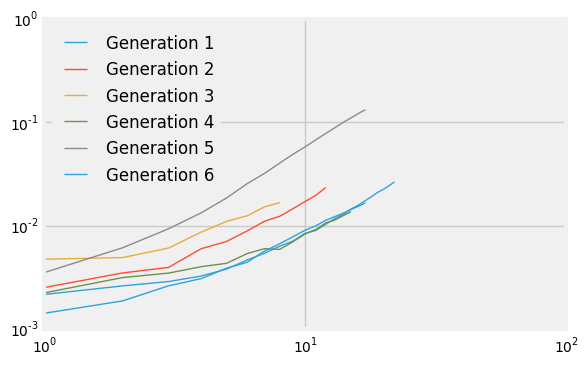

In [216]:
genmsds = {}
for x in range(1,len(division)+1):
    delays, msds =compute_msd(gendict[x],  t_step=1)
    plt.plot(delays, msds, label = 'Generation %s'%x,lw=1)
    plt.yscale('log')
    plt.xscale('log')
    genmsds[x] = msds
plt.legend(loc='upper left')

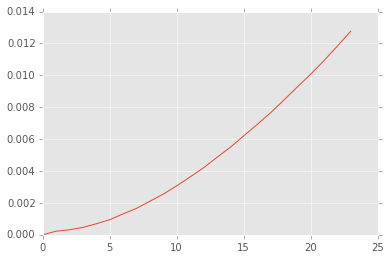

In [184]:
plt.plot(genmsds[1])

/Users/kaito/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


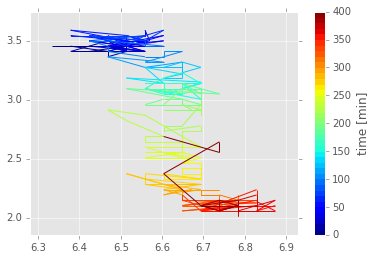

In [185]:
#Create time-coloured trajectory
from matplotlib.collections import LineCollection
from matplotlib import cm

xy = focidf[['XM','YM']].values
z = np.linspace(0, 1, len(focidf))

min, max = (0, len(focidf))
step = 10 #step in color bar

#Using contourf to provide colorbar info, then clearing the figure
Q = [[0,0],[0,0]]
levels = range(min,max+step,step)
CS3 = plt.contourf(Q, levels, cmap=cm.jet)
plt.clf()
lc = LineCollection(zip(xy[:-1], xy[1:]), array=z, cmap=cm.jet)
fig,  ax = plt.subplots(1, 1)
ax.add_collection(lc)
ax.margins(0.1)
ax2= fig.colorbar(CS3)
ax2.set_label('time [min]')
#plt.show()

#fig1 = plt.gcf()

#Calculate MSD
t_step = 1

msddf = focidf.drop(' ',1)
msddf.index=pd.Index(np.arange(len(msddf)), name='t_stamp')
msddf['t'] = np.arange(len(msddf)) * t_step

def compute_msd(trajectory, t_step, coords=['XM', 'YM']):
    numberofDeltaT = int(np.floor(len(msddf)/4))
    delays = trajectory.t[:numberofDeltaT]
    shifts = np.floor(delays[:numberofDeltaT]/t_step).astype(np.int)
    msds = np.zeros(numberofDeltaT)
    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
    return delays, msds

delays, msds = compute_msd(msddf, t_step=t_step)

NameError: name 'delays' is not defined

/Users/kaito/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


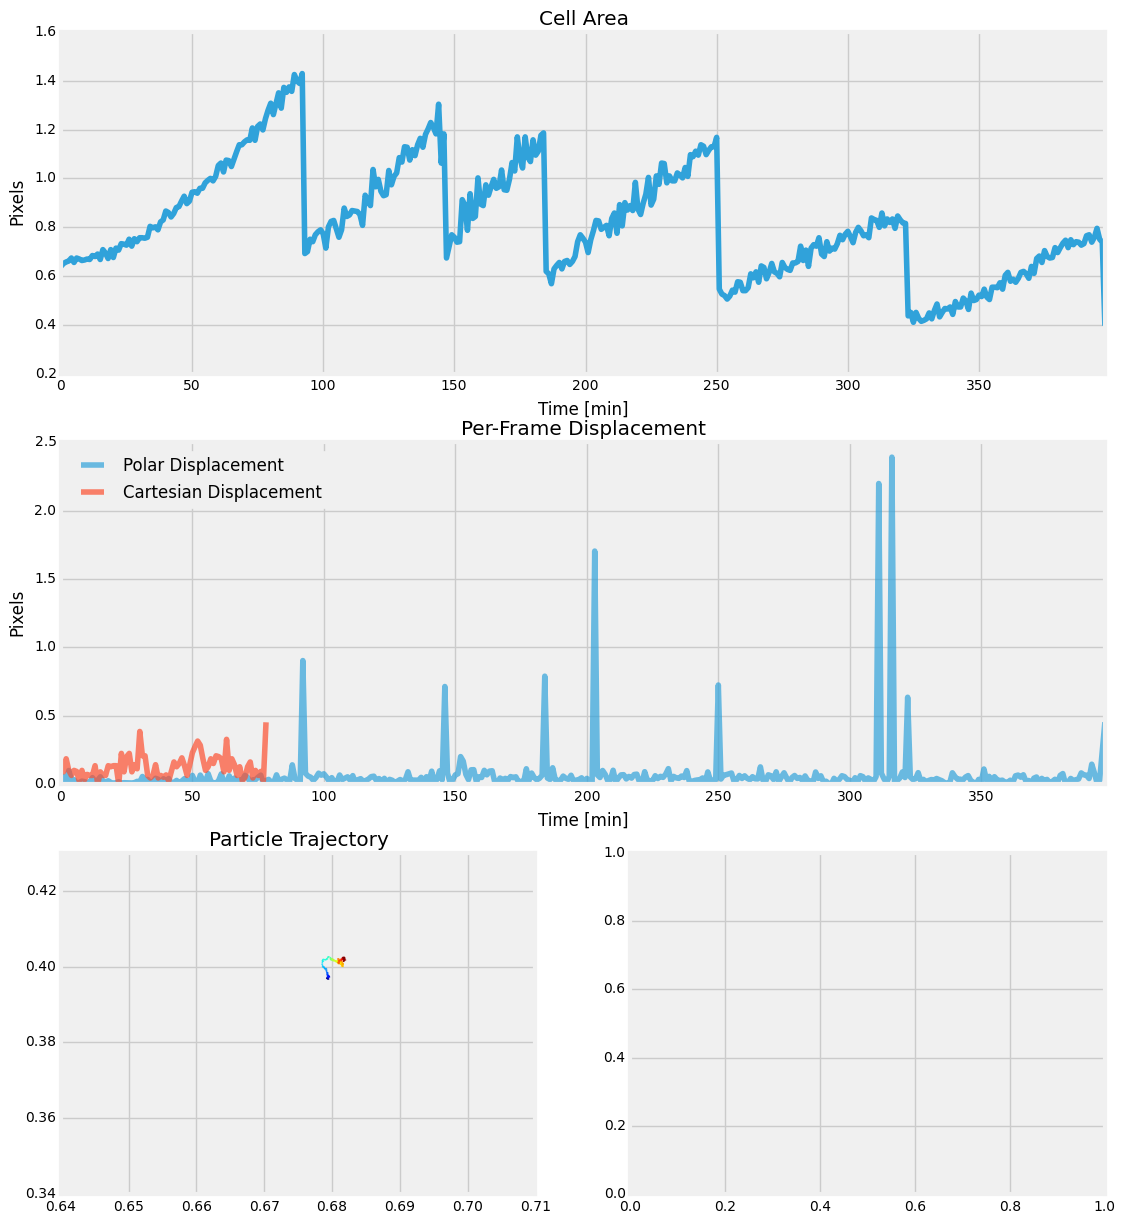

In [170]:
#Generate Summary Fig

#plt.suptitle('Summary of Foci %s' %fociID,  fontsize=20, y = 1.02)

ax1 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,2), (1,0), colspan=2)
ax3 = plt.subplot2grid((3,2), (2, 0))
ax4 = plt.subplot2grid((3,2), (2, 1))

celldf.Area.plot(ax=ax1, figsize = (12,15))
ax1.set_title('Cell Area')
ax1.set_xlabel('Time [min]')
ax1.set_ylabel('Pixels')

polardisp.plot(label = 'Polar Displacement', alpha = 0.7, ax=ax2)
cartdisp.plot( label = 'Cartesian Displacement', alpha = 0.7, ax=ax2)
ax2.set_title('Per-Frame Displacement')
ax2.legend(loc='upper left')
ax2.set_xlabel('Time [min]')
ax2.set_ylabel('Pixels')


ax3.add_collection(lc,autolim=True)
ax3.autoscale_view() 
ax3.set_title('Particle Trajectory')
#ax5= fig.colorbar(CS3)
#ax5.set_label('time [min]')
#ax3.plot(celldf.XM, celldf.YM, 'c-',label = 'Cell Center')
#ax3.legend(loc='lower left')

ax4.plot(delays, msds, 'r')
ax4.set_title('Mean Squared Displacement')
ax4.set_xlabel('Steps')
ax4.set_ylabel('MSD')

plt.tight_layout()

filename = "Summary Foci%s.png"%fociID
savedir ='/Volumes/Kikuchi-SSD/150701F3-muNS-Per2/F3-muNS-30deg-M9glycas-0.2mMIPTG1h-bin2-TxRed300-GFP500-1minint_1/Python_Processed/Graphs/'
#plt.savefig(savedir+filename)

### References
#### MSD
http://stackoverflow.com/questions/7489048/calculating-mean-squared-displacement-msd-with-matlab#

http://damcb.com/mean-square-disp.html

### Influence of Generation Time upon Correlation between Cell Growth and Mean Polar Displacement
In the case of position 7A, generations with generation times 86 and 89min were not on the trend shown on generations below 60min. Perhaps I could improve correlation by ommiting long generations.

-> Update: this seems not to be a general thing... 

-> Update: the second and second last generations seem to be likely to be outliers? pos5F

/Users/kaito/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


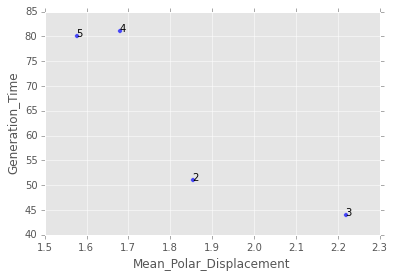

In [126]:
ax = gendf.plot(kind='scatter', x = 'Mean_Polar_Displacement', y = 'Generation_Time', alpha=0.7,color='Blue')
for i, txt in enumerate(gendf.index):
    ax.annotate(txt, (gendf.Mean_Polar_Displacement.iloc[i],gendf.Generation_Time.iloc[i]))

### 150909BossDiscussion
- Check relation of foci displacement and cell size. Larger cells mean that the foci would appear to move longer compared to that within smaller cells.
- Per-frame cell size and per-frame foci displacement correlation = linear?
- Fit cell elongation with a exponential function and obtain smoothed cell size
- Compare two distinct foci within cells with same size: will their displacement differ?


In [ ]:
celldf.plot(kind='scatter', x='Area', y='Polar_Displacement');